In [1]:
import sys
import os
sys.path.append('/Users/syesw/Desktop/JL-Code_Project/athena')

In [2]:
from dotenv import load_dotenv
load_dotenv()

rqdata_username = os.getenv('RQDATA_USERNAME')
rqdata_password = os.getenv('RQDATA_PASSWORD')

In [3]:
import rqdatac as rq
import pandas as pd

In [4]:
from athena import RiceQuantDataHandler, Strategy, Backtest
from athena import sort_the_factor
from athena import run_weekly, run_monthly

In [5]:
# 设置时间范围
start_date = '2005-01-01'
end_date = '2020-01-01'
#asset_list = ['000651.XSHE', '600000.XSHG']
#asset_list = rq.index_components('000300.XSHG')
rqdata = RiceQuantDataHandler(start_date, end_date)
rqdata.auth(rqdata_username,rqdata_password)

asset_list = rqdata.get_index_list('000300.XSHG')

In [6]:
len(asset_list)

300

In [7]:
factor_data = rqdata.get_factors_from_ricequant(list=asset_list, factors=['market_cap'])

开始获取数据
数据获取完成
开始转换数据结构


In [8]:
backtest_data = rqdata.get_prices_from_ricequant(list=asset_list, fields=['open', 'high', 'low', 'close', 'volume'])

开始获取数据
数据获取完成
开始转换数据结构


In [28]:
class SortedFactorInvestStrategy(Strategy):
    def init(self):
        print("回测准备:")
        self.first_time = True

    @run_monthly
    def next(self, i, record):
        print("----------------------")
        date = self.data.index[i]
        print(str(date) + ': ')

        current_long_positions, current_short_positions = self.broker.current_position_status()
        print("我目前持仓情况:")
        print("多头仓位:", current_long_positions)
        print("空头仓位:", current_short_positions)

        day_factors = factor_data.loc[date] # 当天的因子数据
        sorted_factor_series = sort_the_factor(day_factors, 'market_cap') # 从高到低排因子

        print('因子排名前5的股票:')
        print(sorted_factor_series[:5].index.tolist())
        short_stocks = sorted_factor_series[:5].index.tolist()
        #short_stocks = []
        print('因子排名后5的股票:')
        print(sorted_factor_series[-5:].index.tolist())
        long_stocks = sorted_factor_series[-5:].index.tolist()

        # 先换仓
        long_closed = short_closed = 0
        for stock in current_long_positions:
            # 对于我目前的所有多头仓位,如果不在新的list里，则平仓
            if stock not in long_stocks:
                print("关多仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Close')])
                long_closed += 1
        for stock in current_short_positions:
            if stock not in short_stocks:
                print("关空仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Close')])
                short_closed += 1

        total_closed = long_closed + short_closed
        if self.first_time == True:
            re_invest_size = 1 / 10 # 10只股票
        else: re_invest_size = 1 / total_closed # 关了多少，就重新开多少

        # 买进新的股票
        # 这里的换仓逻辑是，不去干涉已经开仓的股票(不加仓)
        # 对于新开仓的股票，按可分配资金的数量(1/total_closed)来开仓
        # 这样做实现了滚仓的效果
        for stock in long_stocks:
            if long_closed == 0 and self.first_time == False:
                break
            if stock not in current_long_positions:
                print("新开多仓:", stock)
                self.open(symbol=stock, size=re_invest_size, price=record[(stock,'Open')], short=False)
                long_closed -= 1
        for stock in short_stocks:
            if short_closed == 0 and self.first_time == False:
                break
            if stock not in current_short_positions:
                print("新开空仓:", stock)
                self.open(symbol=stock, size=re_invest_size, price=record[(stock,'Open')], short=True)
                short_closed -= 1
        
        self.first_time == False

        print("----------------------")


In [29]:
backtest = Backtest(SortedFactorInvestStrategy, backtest_data, commission=.001, cash=100_0000)

In [30]:
res = backtest.run()

回测准备:
----------------------
2005-01-04 00:00:00: 
我目前持仓情况:
多头仓位: []
空头仓位: []
因子排名前5的股票:
['600028.XSHG', '600011.XSHG', '600019.XSHG', '600900.XSHG', '600050.XSHG']
因子排名后5的股票:
['600346.XSHG', '600703.XSHG', '000703.XSHE', '600369.XSHG', '600109.XSHG']
新开多仓: 600346.XSHG
新开多仓: 600703.XSHG
新开多仓: 000703.XSHE
新开多仓: 600369.XSHG
新开多仓: 600109.XSHG
新开空仓: 600028.XSHG
新开空仓: 600011.XSHG
新开空仓: 600019.XSHG
新开空仓: 600900.XSHG
新开空仓: 600050.XSHG
----------------------
----------------------
2005-02-03 00:00:00: 
我目前持仓情况:
多头仓位: ['600346.XSHG', '600703.XSHG', '000703.XSHE', '600369.XSHG', '600109.XSHG']
空头仓位: ['600028.XSHG', '600011.XSHG', '600019.XSHG', '600900.XSHG', '600050.XSHG']
因子排名前5的股票:
['600028.XSHG', '600011.XSHG', '600019.XSHG', '600900.XSHG', '600050.XSHG']
因子排名后5的股票:
['600340.XSHG', '600369.XSHG', '600703.XSHG', '000703.XSHE', '600109.XSHG']
关多仓: 600346.XSHG
新开多仓: 600340.XSHG
----------------------
----------------------
2005-03-07 00:00:00: 
我目前持仓情况:
多头仓位: ['600703.XSHG', '000703.XSHE', '600

In [25]:
len(res.trades)

434

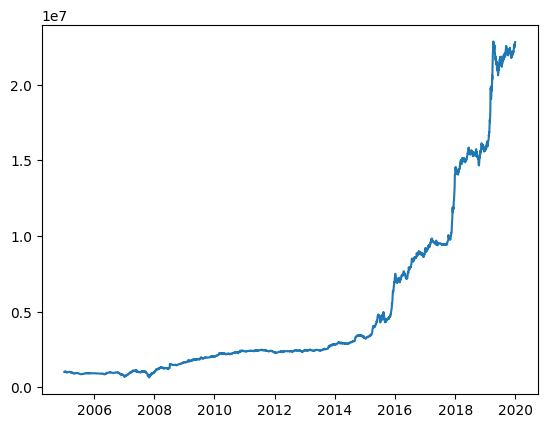

In [31]:
import matplotlib.pyplot as plt
plt.plot(res.returns)

In [27]:
res.returns

2005-01-04    9.941401e+05
2005-01-05    1.007014e+06
2005-01-06    1.001259e+06
2005-01-07    1.006420e+06
2005-01-10    1.012618e+06
                  ...     
2019-12-25    2.258326e+07
2019-12-26    2.270224e+07
2019-12-27    2.270526e+07
2019-12-30    2.282091e+07
2019-12-31    2.287052e+07
Length: 3646, dtype: float64

In [14]:
trades = pd.DataFrame(res.trades)
trades

,symbol,short,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
0,600346.XSHG,False,2005-01-04,2005-02-03,0.4671,0.4413,213873.046243,-5517.924593,-5.523443,194.282275,9.942878e+05
1,600340.XSHG,False,2005-02-03,2005-04-06,0.2073,0.2094,213470.192727,448.287405,1.013025,88.953029,9.946471e+05
2,600050.XSHG,True,2005-01-04,2005-04-06,1.8399,1.6469,21035.570169,4059.865043,10.489701,73.346826,9.986336e+05
3,600346.XSHG,False,2005-04-06,2005-10-10,0.3823,0.3777,127012.442102,-584.257234,-1.203244,96.529456,9.979529e+05
4,000661.XSHE,False,2005-10-10,2005-11-09,1.1480,1.1759,38430.948486,1072.223463,2.430314,89.309681,9.989358e+05
...,...,...,...,...,...,...,...,...,...,...,...
160,600583.XSHG,False,2019-09-11,2019-10-11,5.0697,5.4089,280372.410879,95102.321770,6.690731,2937.910345,2.321911e+07
161,300070.XSHE,False,2019-07-12,2019-11-11,7.1893,7.2761,250767.856077,21766.649908,1.207350,3627.457345,2.323725e+07
162,000423.XSHE,False,2019-08-12,2019-11-11,27.5491,30.6904,49530.512362,155590.198482,11.402550,2884.632275,2.338996e+07
163,600733.XSHG,False,2019-10-11,2019-12-11,6.3200,6.1400,248390.609011,-44710.309622,-2.848101,3094.946988,2.334215e+07


In [15]:
open_pos = pd.DataFrame(res.open_positions)
open_pos

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value,is_short
0,601398.XSHG,2006-11-08,2019-12-31,1.4391,4.4348,35265.676765,-105645.387885,-208.164825,-5.489455e+04,True
1,601939.XSHG,2007-10-08,2019-12-31,4.0940,5.4821,17453.435006,-24227.113132,-33.905716,4.722725e+04,True
2,601288.XSHG,2010-08-11,2019-12-31,1.2755,2.7361,95920.322658,-140101.223274,-114.511956,-1.775485e+04,True
3,601318.XSHG,2018-03-14,2019-12-31,52.5132,68.6396,19560.514083,-315440.674303,-30.709231,7.117445e+05,True
4,600519.XSHG,2019-07-12,2019-12-31,895.4179,1079.4654,1467.777513,-270140.781847,-20.554369,1.044133e+06,True
5,002081.XSHE,2019-10-11,2019-12-31,7.7653,7.9825,224621.592777,48787.809951,2.797059,1.793042e+06,False
6,002294.XSHE,2019-10-11,2019-12-31,17.8829,18.4951,79005.406509,48367.109865,3.423382,1.461213e+06,False
7,600566.XSHG,2019-11-11,2019-12-31,20.3851,20.2761,70876.705409,-7725.560890,-0.534704,1.437103e+06,False
8,600816.XSHG,2019-12-11,2019-12-31,3.9100,4.4400,413498.149848,219154.019420,13.554987,1.835932e+06,False
9,300024.XSHE,2019-12-11,2019-12-31,13.9500,14.0000,104308.242962,5215.412148,0.358423,1.460315e+06,False
